# 1991 ~ 2018 KBO 타자 데이터를 이용한 연봉 예측

### 바로가기

-----

### 필요한 라이브러리 import

In [273]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

mpl.rc('font', family='NanumGothic')  # matplotlib에서 한글 폰트로 NanumGothic을 사용

# 1. 데이터 불러오기

[원본 데이터(kaggle.com)](https://www.kaggle.com/bluemumin/kbo-baseball-for-kaggle)

In [275]:
batter = pd.read_csv('./data/1990_2018_KBO_Batter.csv')
batter.columns

Index(['Batter_Name', 'Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR',
       'TB', 'RBI', 'SB', 'CS', 'BB', 'HBP', 'FBP', 'IBB', 'SO', 'GDP', 'SAC',
       'SF', 'Year', 'Salary', 'WAR', 'Year_Born', 'Hand', 'CP', 'TP', 'AVG',
       'OBP', 'SLG', 'OPS', 'P_Year', 'YAB', 'YOPS'],
      dtype='object')

In [276]:
batter.head()

,Batter_Name,Age,G,PA,AB,R,H,1B,2B,3B,...,Hand,CP,TP,AVG,OBP,SLG,OPS,P_Year,YAB,YOPS
0,백용환,24,26,58,52,4,9,5,4,0,...,우타우투,포수,포수,0.173,0.259,0.250,0.509,2014,79,0.580
1,백용환,25,47,86,79,8,14,8,2,0,...,우타우투,포수,포수,0.177,0.226,0.354,0.580,2015,154,0.784
2,백용환,26,65,177,154,22,36,20,6,0,...,우타우투,포수,포수,0.234,0.316,0.468,0.784,2016,174,0.581
3,백용환,27,80,199,174,12,34,23,7,0,...,우타우투,포수,포수,0.195,0.276,0.305,0.581,2017,17,0.476
4,백용환,28,15,20,17,2,3,3,0,0,...,우타우투,포수,포수,0.176,0.300,0.176,0.476,2018,47,0.691


### 속성 정리

G 게임 수 | Age 나이 | PA 타석 | AB 타수 | R 득점 | H 안타 | 1B 1루타 | 2B 2루타 | 3B 3루타 | HR 홈런 | TB 총 루타 수 | RBI 타점 | SB 도루 성공 | 

CS 도루 실패 | FBP(BB + HBP) | BB 볼넷 수 | HBP 몸에 맞는 공 | IBB 고의 사구 | SO 삼진 | GDP 병살 | SAC 희생타 | SF 희생 플라이 | Year 해당 시즌 | 

Salary 해당 시즌의 연봉 | WAR 대체 선수 대비 승리 기여도 | Year_Born 선수 출생일 | Hand 타석 위치 | CP 최근 포지션 | TP 통합 포지션 | AVG 타율 | 

OBP 출루율 | SLG 장타율 | OPS(OBP + SLG) | P_Year 다음 시즌 | YAB 다음 시즌 타석 수 | YOPS 다음 시즌 OPS



In [277]:
print(batter.shape)

(1913, 37)


<b>연봉 정보</b>

In [278]:
batter['Salary'].describe()  # 단위: 만 원

count      1913.000000
mean      14112.135389
std       22446.615221
min        1700.000000
25%        2700.000000
50%        5300.000000
75%       15000.000000
max      250000.000000
Name: Salary, dtype: float64

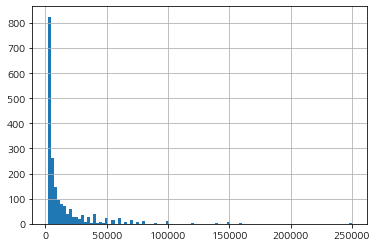

In [279]:
batter['Salary'].hist(bins=100)  # 연봉 분포 출력

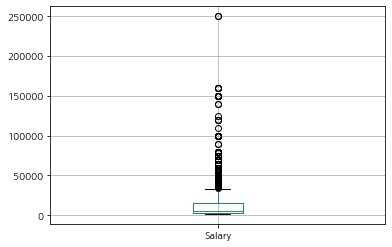

In [280]:
batter.boxplot(column=['Salary'])

<b>Box Plot?</b>

상자 그림(Box Plot)은 데이터의 사분위값 특성을 이용하여 데이터의 분포를 파악하는 그림 표현 방법.

데이터의 기준을 제시해주는 그림. 그림 상에서 급여가 25000(만 원)이 넘는 데이터는 일반적이지 않다고 볼 수 있음.

-----

### 회귀 분석에 사용할 특성

In [289]:
batter_features_df = batter.drop(['Batter_Name', 'Year_Born', 'P_Year', 'YAB', 'YOPS'], axis=1)

In [298]:
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [25, 30]
    fig = plt.figure(1)
    
    # df의 column 개수 만큼의 subplot을 출력
    for i in range(len(df.columns)):
        ax = fig.add_subplot(8, 4, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.show()

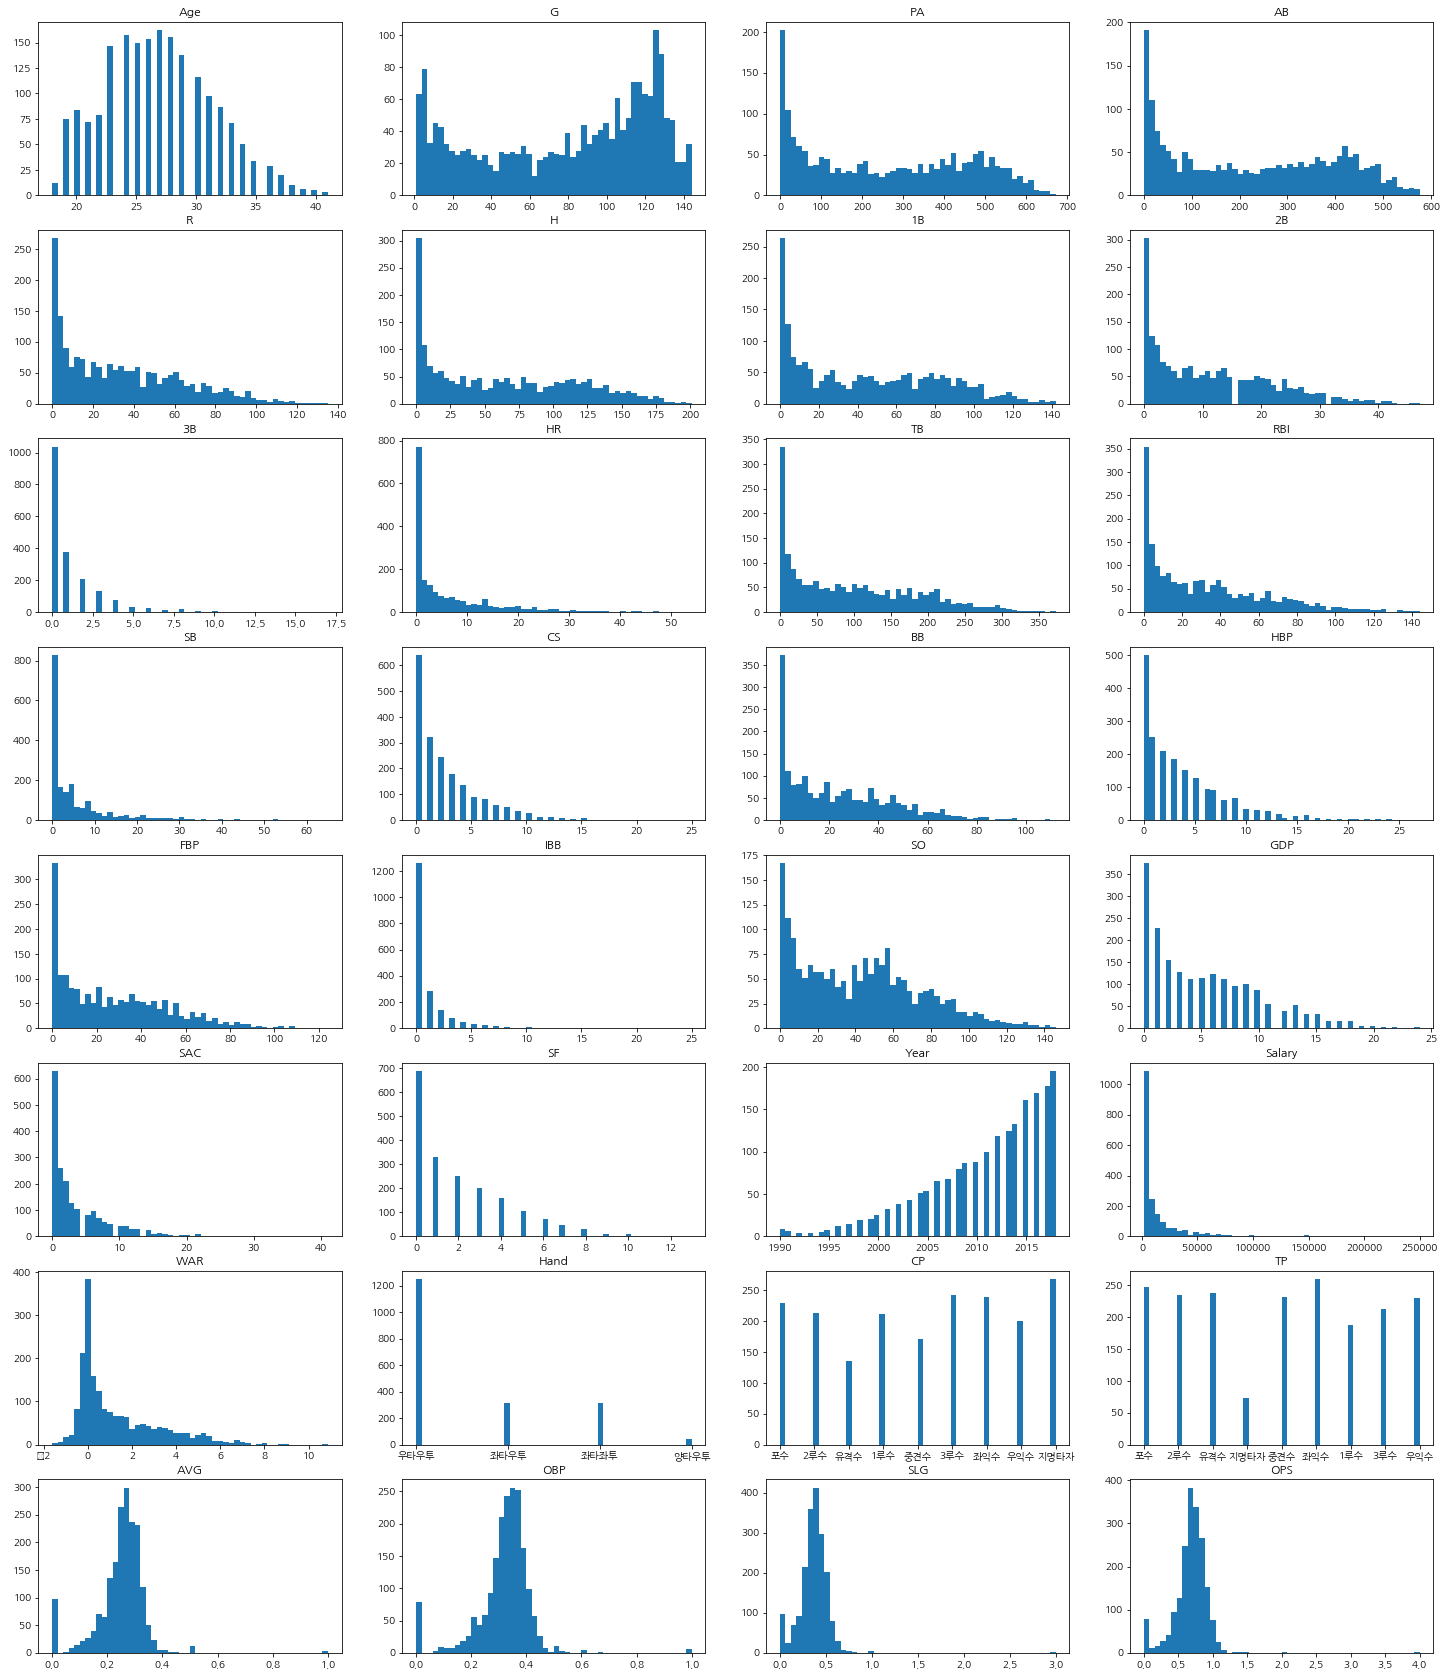

In [300]:
plot_hist_each_column(batter_features_df)

-----

# 2. 타자의 연봉 예측하기

### 특성 단위 맞춰주기: 스케일링

## 필요한 데이터만 추출

In [235]:
data = data.drop(['Batter_Name', 'Year_Born', 'P_Year', 'YAB', 'YOPS'], axis=1)
data.columns

Index(['Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'TB', 'RBI',
       'SB', 'CS', 'FBP', 'GB', 'SO', 'GDP', 'BU', 'SF', 'Salary', 'WAR',
       'Hand', 'CP', 'TP', 'Avg', 'OPS'],
      dtype='object')

## Categorical 컬럼 변환

In [236]:
data.columns = ['Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'TB', 'RBI', 'SB', 'CS', 'FBP', 'GB', 'SO', 'GDP', 'BU', 'SF', 'Salary', 'WAR', 'Hand', 'CP', 'TP', 'Avg', 'OPS']
data['Hand'] = pd.Categorical(data['Hand'])
data['CP'] = pd.Categorical(data['CP'])
data['TP'] = pd.Categorical(data['TP'])

## 목표변수 파악

In [237]:
data.dtypes

Age          int64
G            int64
PA           int64
AB           int64
R            int64
H            int64
1B           int64
2B           int64
3B           int64
HR           int64
TB           int64
RBI          int64
SB           int64
CS           int64
FBP          int64
GB           int64
SO           int64
GDP          int64
BU           int64
SF           int64
Salary       int64
WAR        float64
Hand      category
CP        category
TP        category
Avg        float64
OPS        float64
dtype: object

## Categorical Data 수치화
학습 모델이 해당 데이터를 인지할 수 있도록 수치화된 값으로 변환하는 과정 필요

아래의 3개 컬럼이 현재 Categorical Data

In [238]:
data['Hand'].value_counts()

우타우투    1247
좌타우투     313
좌타좌투     312
양타우투      41
Name: Hand, dtype: int64

In [239]:
data['CP'].value_counts()

지명타자    268
3루수     243
좌익수     240
포수      230
2루수     213
1루수     212
우익수     200
중견수     172
유격수     135
Name: CP, dtype: int64

In [240]:
data['TP'].value_counts()

좌익수     259
포수      247
유격수     238
2루수     234
중견수     232
우익수     230
3루수     213
1루수     187
지명타자     73
Name: TP, dtype: int64

In [241]:
# Encoding categorical data
data = pd.concat([data, pd.get_dummies(data['Hand'], prefix='Hand')], axis=1)
data = pd.concat([data, pd.get_dummies(data['CP'], prefix='CP')], axis=1)
data = pd.concat([data, pd.get_dummies(data['TP'], prefix='TP')], axis=1)
data = data.drop(['Hand', 'CP', 'TP'], axis=1)
data.columns

Index(['Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'TB', 'RBI',
       'SB', 'CS', 'FBP', 'GB', 'SO', 'GDP', 'BU', 'SF', 'Salary', 'WAR',
       'Avg', 'OPS', 'Hand_양타우투', 'Hand_우타우투', 'Hand_좌타우투', 'Hand_좌타좌투',
       'CP_1루수', 'CP_2루수', 'CP_3루수', 'CP_우익수', 'CP_유격수', 'CP_좌익수', 'CP_중견수',
       'CP_지명타자', 'CP_포수', 'TP_1루수', 'TP_2루수', 'TP_3루수', 'TP_우익수', 'TP_유격수',
       'TP_좌익수', 'TP_중견수', 'TP_지명타자', 'TP_포수'],
      dtype='object')

In [242]:
data.dtypes

Age            int64
G              int64
PA             int64
AB             int64
R              int64
H              int64
1B             int64
2B             int64
3B             int64
HR             int64
TB             int64
RBI            int64
SB             int64
CS             int64
FBP            int64
GB             int64
SO             int64
GDP            int64
BU             int64
SF             int64
Salary         int64
WAR          float64
Avg          float64
OPS          float64
Hand_양타우투      uint8
Hand_우타우투      uint8
Hand_좌타우투      uint8
Hand_좌타좌투      uint8
CP_1루수         uint8
CP_2루수         uint8
CP_3루수         uint8
CP_우익수         uint8
CP_유격수         uint8
CP_좌익수         uint8
CP_중견수         uint8
CP_지명타자        uint8
CP_포수          uint8
TP_1루수         uint8
TP_2루수         uint8
TP_3루수         uint8
TP_우익수         uint8
TP_유격수         uint8
TP_좌익수         uint8
TP_중견수         uint8
TP_지명타자        uint8
TP_포수          uint8
dtype: object

## NA / NAN Data 처리

In [243]:
data = data.fillna(0)

## 분석 데이터 분할

In [244]:
X = data.drop('Salary', axis=1)
y = data['Salary']

print(X.shape, y.shape)
print(data['WAR'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train.iloc[shuffle_index], y_train.iloc[shuffle_index]

(1913, 45) (1913,)
0      -0.055
1      -0.441
2       0.783
3      -0.405
4      -0.130
        ...  
1908    3.315
1909    0.215
1910   -0.271
1911    2.365
1912    5.356
Name: WAR, Length: 1913, dtype: float64


## 회귀 모형 적합

- 경사하강법(일반, 확률, 배치, 미니배치)

- 몇 개의 특성만 실제 유용할 것이라고 의심: 라쏘

- 라쏘가 불규칙하게 행동할 수 있음: 엘라스틱 넷

- 불규칙한 행동이 없는 라쏘를 원하면 엘라스틱넷에 혼합 비율을 1에 가깝게 설정

- SVM 회귀

## 라쏘 회귀

In [245]:
from sklearn.metrics import r2_score

from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.1, max_iter=100, tol=1)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)

print(lasso)
print("r^2 on test data: %f" % r2_score_lasso)

print(lasso.score(X_train, y_train))  # 0.5345918315079097
print(lasso.score(X_test, y_test))  # 0.38975303863077965

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=100, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=1, warm_start=False)
r^2 on test data: 0.401348
0.47437143597924536
0.40134752768246307


결과가 엉망...

## 엘라스틱 넷

In [246]:
enet = linear_model.ElasticNet(alpha=0.1, l1_ratio=0.8, tol=1)
enet.fit(X_train, y_train)

y_pred_enet = enet.predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)

print(enet)
print("r^2 on test data: %f" % r2_score_enet)

print(enet.score(X_train, y_train))  # 0.5345918315079097
print(enet.score(X_test, y_test))  # 0.38975303863077965

print(enet.coef_)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.8,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=1, warm_start=False)
r^2 on test data: 0.400857
0.4674389608417908
0.4008567284907606
[ 1.84082950e+03  1.00844665e+02  1.67112981e+01 -7.46947871e-01
  6.02102385e+01 -2.35513096e+00 -1.60447165e+01  3.51962933e+01
 -9.85319739e+02  4.09934015e+02 -1.34852659e+01  9.95908656e+00
  3.44315107e-01 -4.45564707e+02  1.03694275e+01  1.62057105e+03
 -1.12026053e+02  2.39459543e+02 -7.15917541e+02  1.12505926e+02
  5.65517042e+02  5.79796976e+02 -1.77062057e+03 -1.20534863e+03
 -7.11956729e+02  1.88606984e+03 -1.02546222e+03 -2.14368647e+03
  8.88654557e+02  7.92484062e+02 -1.60634793e+03  6.63934991e+02
 -2.91444172e+03  4.08406073e+03 -7.85180363e+01 -3.20869603e+02
  4.20127430e+03 -9.23800688e+01  7.88922387e+02 -5.89427186e+02
  1.52764691e+03 -1.27303310e+03  1.18149576e+03 -3.73201005e+03

마찬가지로 결과가 좋지 않다.

데이터 전처리, 적합한 알고리즘 사용에 더 신경을 써야겠다고 판단했다.

뭘 먼저 해야할까... 검색해보니 <b>스케일링</b>과 <b>다중 공선성</b>이라는 개념이 나왔다.

### 스케일링
일단 데이터를 모델링 하기 전에는 반드시 스케일링 과정을 거쳐야 한다. 스케일링을 통해 다차원의 값들을 비교 분석하기 쉽게 만들어주며, 자료의 오버플로우(Overflow)나 언더플로우(Underflow)를 방지 하고, 독립 변수의 공분산 행렬의 조건수(condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상시킨다.

### 다중 공선성
한 종속변수의 값을 예측하기 위해서 다양한 변수를 사용하는데, 그 모든 변수들이 독립적인 것이 아닐 수 있다. 한 변수가 다른 변수와 비슷한 결과를 나타내기도 하는데, 그렇게 중복된 데이터가 섞이게 되면 데이터의 복잡성을 높이고, 불필요한 계산이 들어가기 때문에 정확도가 더 줄어들게 된다.

차근차근 반영해보자.

In [254]:
# 스케일링 (Min-Max Scaling)
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
fitted = standardScaler.fit(data)
df = data.copy()
output = min_max_scaler.transform(data)
output = pd.DataFrame(output, columns=df.columns, index=list(df.index.values))
print(output.head())

        Age         G        PA        AB         R         H        1B  \
0  0.260870  0.174825  0.086310  0.090278  0.029630  0.044776  0.035211   
1  0.304348  0.321678  0.127976  0.137153  0.059259  0.069652  0.056338   
2  0.347826  0.447552  0.263393  0.267361  0.162963  0.179104  0.140845   
3  0.391304  0.552448  0.296131  0.302083  0.088889  0.169154  0.161972   
4  0.434783  0.097902  0.029762  0.029514  0.014815  0.014925  0.021127   

         2B   3B        HR  ...  CP_포수  TP_1루수  TP_2루수  TP_3루수  TP_우익수  \
0  0.085106  0.0  0.000000  ...    1.0     0.0     0.0     0.0     0.0   
1  0.042553  0.0  0.074074  ...    1.0     0.0     0.0     0.0     0.0   
2  0.127660  0.0  0.185185  ...    1.0     0.0     0.0     0.0     0.0   
3  0.148936  0.0  0.074074  ...    1.0     0.0     0.0     0.0     0.0   
4  0.000000  0.0  0.000000  ...    1.0     0.0     0.0     0.0     0.0   

   TP_유격수  TP_좌익수  TP_중견수  TP_지명타자  TP_포수  
0     0.0     0.0     0.0      0.0    1.0  
1     0.0     0.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train.iloc[shuffle_index], y_train.iloc[shuffle_index]

lasso = linear_model.Lasso(alpha=0.1, max_iter=100000, tol=1e-4)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)

print(lasso)
print("r^2 on test data: %f" % r2_score_lasso)

print(lasso.score(X_train, y_train))  # 0.47437143597924536
print(lasso.score(X_test, y_test))  # 0.40134752768246296

In [ ]:
!^C

In [ ]:
from statsmodels.datasets.longley import load_pandas

dfy = load_pandas().endog
dfX = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX)
plt.show()